# Group 16: SIT307 Machine Learning Group Project (Assignment 3)

Dataset Selected: <b>COVID-19 World Vaccination Progress</b>

Found at: https://www.kaggle.com/gpreda/covid-world-vaccination-progress

Collected by: <b>Gabriel Preda</b>

Updated: <b>Daily</b>

Date of download used: <b>6th May 2021</b>

<br><br>
Supplementary data sets found at:

https://www.kaggle.com/tanuprabhu/population-by-country-2020

https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

Import libraries used

In [1]:
# import libraries used
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt

In [2]:
""" 
    Funtion that calculates mean squared error
    Requires:
        predictions made by model
        Ytest correct outcomes
"""
def MSE(predictions, Ytest):
    return np.mean((predictions - Ytest) ** 2)

In [3]:
""" 
    Funtion convert date in string format to ordinal
    Requires:
        a date in string format (DD/MM/YYYY)
"""
def date_to_ordinal(date):
    return datetime.strptime(date, '%d/%m/%Y').date().toordinal()

In [4]:
""" 
    Funtion convert date column in string/object format to ordinal
    Requires:
        a date column in a dataframe
"""

def date_to_ordinal_df(df):
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].map(dt.datetime.toordinal)
    return df

In [5]:
""" 
    Funtion convert ordinal number to datetime format
    Requires:
        an ordinal number
"""
def ordinal_to_datetime(ordinal):
    ordinal_to_datetime = int(ordinal)
    ordinal_to_datetime = dt.date.fromordinal(abs(ordinal_to_datetime))
    return ordinal_to_datetime

In [6]:
""" 
    Funtion convert date column in ordianl format to date
    Requires:
        a date column in a dataframe in ordinal
"""
def ordinal_to_datetime_arr(arr):
    new_arr = []
    for num in arr:
        num = int(num)
        new_arr.append(dt.date.fromordinal(abs(num)))
    return new_arr

In [7]:
""" 
    Funtion that plots linear regression and real data
    Requires:
        X data set
        Y data set
        X test data set
        predictions made by model
"""
def plot_LR(X, Y, Xtest, predictions):
    # Plot outputs
    plt.scatter(X, Y,  color='red', s=5)
    plt.plot(Xtest, predictions, color='blue', linewidth=3)
    plt.xticks(rotation=90)

    # show plot
    plt.show()

### Kelly's Section

Section for Kelly to implement, test and apply machine learning.

In [8]:
kel_vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [9]:
# take only the columns of interest
kel_vaccination = kel_vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]
# show this shape
print(kel_vaccination.shape)

(15344, 3)


In [10]:
# drop all na rows where no data for people fully vaccinated per hundred
kel_vaccination = kel_vaccination[kel_vaccination['people_fully_vaccinated_per_hundred'].notna()]

# change date object to date time and then ordinal to be used in linear regression
date_to_ordinal_df(kel_vaccination)

# print the new shape
print(kel_vaccination.shape)

(6343, 3)


In [11]:
""" 
    Function to find a date of the given target percentage for the population fully vaccinated
    Requires:
        -the pandas dataframe being worked on
        -a valid country in string format, and
        -target percentage
"""

def date_to_be_target_percentage(df, country, percentage, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        determin_date = (LR.intercept_ - percentage )/LR.coef_
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the date of the target percentage for the fully vaccinated of country population
        # the mean squared error, the Y intercept and the slope
        return determin_date, mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print(country, "has no data for people_fully_vaccinated_per_hundred.")
        return False, False, False, False

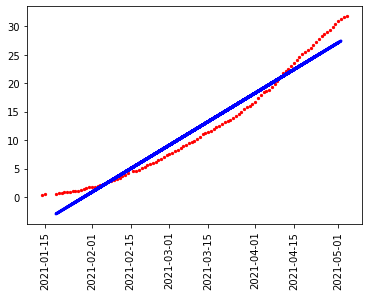

We predict that 70% of the United States population will be immunized by 2021-09-23.


In [12]:
# determine a country to investigate
country = 'United States'
# determine a date
target_percentage_of_immunization = 70

# call function with the dataset, country and target_percentage_of_immunization
# store returned values to be printed
date, mse, y_intercept, slope = date_to_be_target_percentage(kel_vaccination, country, target_percentage_of_immunization, True)
print("We predict that {0}% of the {1} population will be immunized by {2}.".format(target_percentage_of_immunization,country,ordinal_to_datetime(date)))

### Muz's Section

Section for Muz to implement, test and apply machine learning.

In [13]:
muz_vaccination = pd.read_csv('data/cleaned_vaccination.csv')

### Asher's Section

Section for Asher to implement, test and apply machine learning.

In [14]:
ash_vaccination = pd.read_csv('data/cleaned_vaccination.csv')

### Tung's Section

Section for Tung to implement, test and apply machine learning.

In [15]:
tung_vaccination = pd.read_csv('data/cleaned_vaccination.csv')

### Patrick's Section

Section for Patrick to implement, test and apply machine learning.

In [13]:
pat_vaccination = pd.read_csv('data/cleaned_vaccination.csv')
pat_country_pop = pd.read_csv('data/population_by_country_2020.csv')

In [14]:
# take only the columns of interest
pat_vaccination = pat_vaccination[['country', 'date', 'people_vaccinated']]
pat_country_pop = pat_country_pop[['Country (or dependency)','Population (2020)']]
# show this shape
print(pat_vaccination.shape)
print(pat_country_pop.shape)

(15344, 3)
(235, 2)


In [15]:
# drop all na rows where no data for people fully vaccinated per hundred
pat_vaccination = pat_vaccination[pat_vaccination['people_vaccinated'].notna()]
# print the new shape
print(pat_vaccination.shape)

(8565, 3)


In [16]:
# change date object to date time and then ordinal to be used in linear regression
pat_vaccination['date'] = pd.to_datetime(pat_vaccination['date'])
pat_vaccination['date'] = pat_vaccination['date'].map(dt.datetime.toordinal)

In [17]:
""" 
    Funtion to determine the number of the given countries population fully vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def numbers_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_vaccinated'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_vaccinated".format(country))
        return False, False, False, False

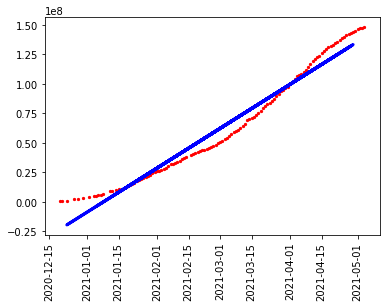

The mean squared error of this model is 66094231474258.26.

United States will have 310082683.04 people fully vaccined by the date 23/09/2021 based on current tracking.


In [19]:
# determine a country to investigate
country = 'United States'
# determine a date
date = '23/09/2021'

# call function with the dataset, country and date
# store returned values to be printed
pop_at_date, mse, y_intercept, slope = numbers_vaccinated_at_date(pat_vaccination, country, date, True)

if pop_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse))
    print()
    
    population = pat_country_pop.loc[pat_country_pop['Country (or dependency)'] == country].iat[0,1]
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if pop_at_date >= population:
        print("{0} with a population of {1} will be full vaccinated at this date:{2}".format(country,population,date))
        #date, mse, y_intercept, slope = date_to_be_target_percentage(pat_vaccination, country, 100, False)
        #print("It is predicted the {0} will fully vaccinate their population on {1}.".format(country,ordinal_to_datetime(date)))
    else:
        # print data
        print("{0} will have {1} people fully vaccined by the date {2} based on current tracking.".format(country, str(round(pop_at_date[0], 2)), date))

### Sean's Section

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries.

Section for Sean to implement, test and apply machine learning.

In [20]:
# read in cleaned dataset to new data frame
sean_vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [21]:
# take only the columns of interest
sean_vaccination = sean_vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]
# show this shape
print(sean_vaccination.shape)

(15344, 3)


In [22]:
# drop all na rows where no data for people fully vaccinated per hundred
sean_vaccination = sean_vaccination[sean_vaccination['people_fully_vaccinated_per_hundred'].notna()]
# print the new shape
print(sean_vaccination.shape)

(6343, 3)


In [23]:
# change date object to date time and then ordinal to be used in linear regression
sean_vaccination['date'] = pd.to_datetime(sean_vaccination['date'])
sean_vaccination['date'] = sean_vaccination['date'].map(dt.datetime.toordinal)

In [24]:
""" 
    Funtion to determine the percentage of the given countries population fully vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_fully_vaccinated_per_hundred".format(country))
        return False, False, False, False

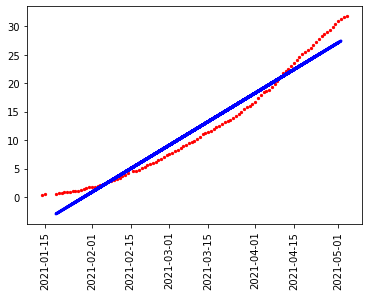

The mean squared error of this model is 3.7973301154785273.

It is predicted the United States will fully vaccinate their population on 2022-01-03.


In [25]:
# determine a country to investigate
country = 'United States'
# determine a date
date = '23/09/2022'

# call function with the dataset, country and date
# store returned values to be printed
perc_at_date, mse, y_intercept, slope = perc_vaccinated_at_date(sean_vaccination, country, date, True)

if perc_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse))
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if perc_at_date > 100:
        date, mse, y_intercept, slope = date_to_be_target_percentage(sean_vaccination, country, 100, False)
        print("It is predicted the {0} will fully vaccinate their population on {1}.".format(country,ordinal_to_datetime(date)))
    else:
        # print data
        print("{0} will have fully vaccined {1}% of their population by the date {2} based on current tracking.".format(country, str(round(perc_at_date[0], 2)), date))

Calculating total number of vaccinations administered at a given date.
<br><br>
This is for countries that don't have data in the dataset for people_fully_vaccinated_per_hundred, so we will use the total number of vaccines administered to get a guide as to how many people may have been vaccinated (2 doses per each member of population so up to 200%)

In [26]:
# read in cleaned dataset to new data frame
sean_vaccination2 = pd.read_csv('data/cleaned_vaccination.csv')

In [27]:
# take only the columns of interest
sean_vaccination2 = sean_vaccination2[['country', 'date', 'total_vaccinations_per_hundred']]
# show this shape
print(sean_vaccination2.shape)

(15344, 3)


In [28]:
# drop all na rows where no data for people fully vaccinated per hundred
sean_vaccination2 = sean_vaccination2[sean_vaccination2['total_vaccinations_per_hundred'].notna()]
# print the new shape
print(sean_vaccination2.shape)

(9232, 3)


In [29]:
# change date object to date time and then ordinal to be used in linear regression
sean_vaccination2['date'] = pd.to_datetime(sean_vaccination2['date'])
sean_vaccination2['date'] = sean_vaccination2['date'].map(dt.datetime.toordinal)

In [30]:
""" 
    Funtion to determine the total vaccinates provided by the given country at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['total_vaccinations_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print(country, "has no data for total_vaccinations_per_hundred.")
        return False, False, False, False

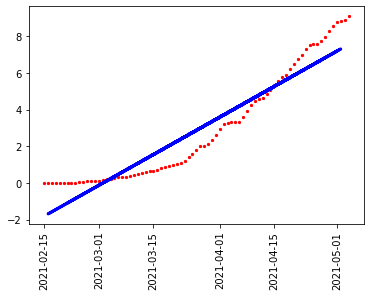

The mean squared error of this model is 0.9690784609237689

Australia will have administered 24.46% of vaccines required to their population by the date 22/09/2021 based on current tracking (200% required for 2 doses for each person).


In [31]:
# determine a country to investigate
country2 = 'Australia'
# determine a date
date2 = '22/09/2021'


# call function with the dataset, country and date
# store returned values to be printed
total_at_date, mse2, y_intercept2, slope2 = perc_vaccinated_at_date(sean_vaccination2, country2, date2, True)
    
if total_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is", mse2)
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    print(country2, "will have administered", str(round(total_at_date[0], 2)) + "% of vaccines required to their population by the date", date2, "based on current tracking (200% required for 2 doses for each person).")